### TODO: 
- add autoregressive features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
from sklearn.metrics import mean_squared_error

In [2]:
TARGET = 'target'

In [3]:
train = pd.read_parquet('data/amman_boosting_train.pq')
test = pd.read_parquet('data/amman_boosting_test.pq')

### Features

In [4]:
train['ts'] = pd.to_datetime(train['ts'])
train[TARGET] = train[TARGET].astype(float)
test['ts'] = pd.to_datetime(test['ts'])
test[TARGET] = test[TARGET].astype(float)

In [5]:
grouped = train[['square_id', TARGET]].groupby(by='square_id', as_index=False).sum()
ids_to_keep = grouped[grouped[TARGET] > 0]['square_id'].values

In [6]:
len(train.square_id.unique())

324

In [7]:
len(ids_to_keep)

109

In [8]:
train = train[train.square_id.isin(ids_to_keep)]
test = test[test.square_id.isin(ids_to_keep)]

In [9]:
len(train)

2186976

In [10]:
pred_ids = np.random.choice(train.pred_index.unique(), size=int(0.3*len(train.pred_index.unique())), replace=False)

train = train[train.pred_index.isin(pred_ids)]

In [11]:
len(train)

654000

In [12]:
train['hour'] = train.ts.dt.hour.astype(str)
train['weekday'] = train.ts.dt.weekday.astype(str)
train['square_id'] = train['square_id'].astype(str)

test['hour'] = test.ts.dt.hour.astype(str)
test['weekday'] = test.ts.dt.weekday.astype(str)
test['square_id'] = test['square_id'].astype(str)

In [13]:
tts = np.sort(train.ts.unique())

n = len(tts)

train_tts = tts[:int(0.8*n)]
val_tts = tts[int(0.8*n):]

val = train[train.ts.isin(val_tts)].copy()
train = train[train.ts.isin(train_tts)].copy()

In [14]:
train = train.drop(['ts', 'pred_index', 'denoised'], axis=1)
val = val.drop(['ts', 'pred_index', 'denoised'], axis=1)

In [15]:
train.head()

,square_id,y_hat,target,hour,weekday
5,107,6.986460,0.0,19,3
6,125,9.448099,1.0,19,3
7,143,2.283820,0.0,19,3
23,106,6.813421,0.0,19,3
24,124,2.289735,0.0,19,3


In [16]:
CAT = ['square_id', 'hour', 'weekday']

### CatBoost

In [22]:
def get_cb():
    return cb.CatBoostRegressor(
        iterations=1000,
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=8.0,
        min_child_samples=4,
        boosting_type='Plain',
        grow_policy='Depthwise',
        random_seed=42,
        early_stopping_rounds=100,
        loss_function='RMSE',
        eval_metric='RMSE',
        max_ctr_complexity=1,
        # langevin=True,
        # subsample=0.9,
        verbose=50
    )

In [23]:
cb_train = cb.Pool(data=train.drop(TARGET, axis=1), label=train[TARGET].values, cat_features=CAT)
cb_val = cb.Pool(data=val.drop(TARGET, axis=1), label=val[TARGET].values, cat_features=CAT)

In [24]:
model = get_cb()

In [25]:
model.fit(cb_train, eval_set=cb_val, use_best_model=True)

0:	learn: 7.9508564	test: 8.1222388	best: 8.1222388 (0)	total: 114ms	remaining: 1m 54s
50:	learn: 4.4433769	test: 4.1077025	best: 4.1077025 (50)	total: 4.95s	remaining: 1m 32s
100:	learn: 4.1537004	test: 3.7769977	best: 3.7769977 (100)	total: 9.16s	remaining: 1m 21s
150:	learn: 4.1177473	test: 3.7481959	best: 3.7481959 (150)	total: 13.3s	remaining: 1m 14s
200:	learn: 4.1039945	test: 3.7391554	best: 3.7389396 (199)	total: 17.1s	remaining: 1m 7s
250:	learn: 4.0987641	test: 3.7364351	best: 3.7364351 (250)	total: 20.7s	remaining: 1m 1s
300:	learn: 4.0951201	test: 3.7353489	best: 3.7352618 (299)	total: 24.1s	remaining: 55.9s
350:	learn: 4.0922801	test: 3.7340202	best: 3.7338588 (336)	total: 27.3s	remaining: 50.5s
400:	learn: 4.0898110	test: 3.7337070	best: 3.7337044 (399)	total: 31s	remaining: 46.2s
450:	learn: 4.0867528	test: 3.7324640	best: 3.7324432 (447)	total: 34.4s	remaining: 41.9s
500:	learn: 4.0843014	test: 3.7310168	best: 3.7310168 (500)	total: 37.7s	remaining: 37.5s
550:	learn: 4.

In [26]:
preds = model.predict(test.drop(['denoised', 'ts', 'pred_index', TARGET], axis=1))
test['cb_preds'] = preds

In [27]:
test.head()

,square_id,y_hat,ts,pred_index,target,denoised,hour,weekday,cb_preds
5,107,1.030176,2023-05-26 14:00:00,0,0.0,1.75,14,4,0.764657
6,125,3.079837,2023-05-26 14:00:00,0,1.0,1.75,14,4,2.743665
7,143,0.000000,2023-05-26 14:00:00,0,0.0,0.00,14,4,0.021894
23,106,0.408148,2023-05-26 14:00:00,0,2.0,2.25,14,4,2.093454
24,124,0.409820,2023-05-26 14:00:00,0,1.0,0.25,14,4,0.728599


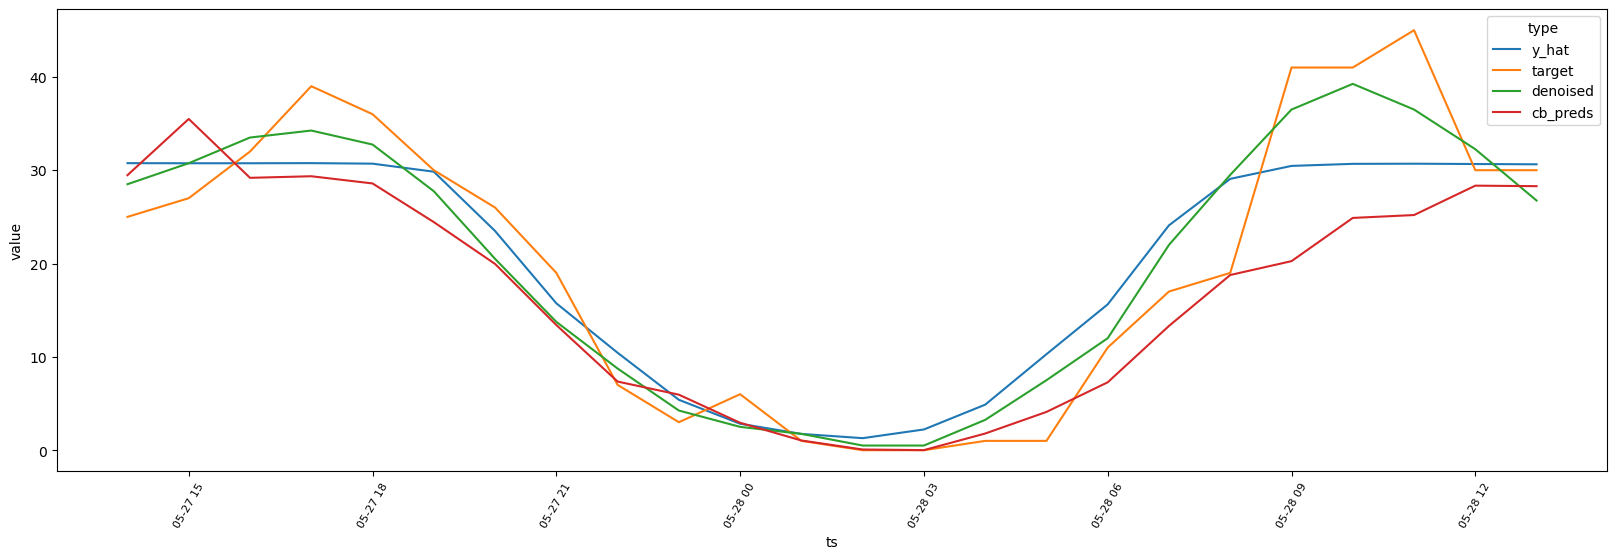

In [29]:
df = test.drop(['pred_index', 'hour', 'weekday'], axis=1)\
    .groupby(['ts', 'square_id'], as_index=False).mean()
df = df[(df.square_id == '102') & (df.ts.isin(np.sort(test.ts.unique())[24*1:24*2]))]
df = df[['ts', 'y_hat', 'target', 'denoised', 'cb_preds']]
df = df.set_index('ts').unstack().reset_index(drop=False).rename(columns={'level_0': 'type', 0: 'value'})
    
plt.figure(figsize=(20, 6))
sns.lineplot(df, x='ts', y='value', hue='type')
plt.xticks(fontsize=8, rotation=60)
plt.show()